In [35]:
import os
import re
import pandas as pd
import json

POSITIVE_DIR = 'data/positive/'
NEGATIVE_DIR = 'data/negative/'

## Load data

Load JSON files generated with PoseNet. 

In [36]:
def load_files(dir_name):
    df = pd.DataFrame()
    files = [f for f in os.listdir(dir_name) if f.endswith('.log') or f.endswith('.json')]
    for f in files:
        with open(dir_name + f) as content:
            data = content.read()
            if "sketch.js:45 poseJSON:  " in data:
                data = data.replace("sketch.js:45 poseJSON:  ", ",")
                data = data[1:-1]
                data = '[{}]'.format(data)
            data = json.loads(data)
            for value in data:
                df_aux = {}
                for scores in value:
                    part = scores['part']
                    df_aux['score_' + part] = scores['score']
                    df_aux['position_x_' + part] = scores['position']['x']
                    df_aux['position_y_' + part] = scores['position']['y']
                df = df.append(df_aux, ignore_index=True)
    return df

In [37]:
df_positive = load_files(POSITIVE_DIR)
df_negative = load_files(NEGATIVE_DIR)
df_positive['class'] = 1
df_negative['class'] = 0
print('Positive:', df_positive.shape)
print('Negative:', df_negative.shape)
df = df_positive.append(df_negative)

Positive: (125, 52)
Negative: (80, 52)


In [38]:
df

,position_x_leftAnkle,position_x_leftEar,position_x_leftElbow,position_x_leftEye,position_x_leftHip,position_x_leftKnee,position_x_leftShoulder,position_x_leftWrist,position_x_nose,position_x_rightAnkle,...,score_nose,score_rightAnkle,score_rightEar,score_rightElbow,score_rightEye,score_rightHip,score_rightKnee,score_rightShoulder,score_rightWrist,class
0,86.689562,475.071675,682.146813,451.837372,421.187606,199.474623,542.782890,81.328669,423.265462,84.529987,...,0.999254,0.034086,0.844763,0.578124,0.999635,0.069375,0.038177,0.979412,0.456421,1
1,594.481567,440.496470,629.739985,424.751727,405.975176,131.047420,511.105264,545.525054,403.456252,500.439976,...,0.998187,0.012726,0.773543,0.448644,0.998898,0.085103,0.080082,0.531657,0.096080,1
2,524.047567,340.148807,538.992868,320.029910,334.361368,313.346987,319.813722,738.636441,287.671730,528.359071,...,0.999554,0.033364,0.932265,0.466368,0.999205,0.078910,0.040251,0.692615,0.773867,1
3,601.338071,355.671068,615.440897,327.842196,312.797671,638.903524,447.185021,411.688589,308.695681,136.831677,...,0.999821,0.020808,0.903296,0.294771,0.999145,0.065031,0.027676,0.773847,0.460311,1
4,101.609927,595.272317,362.193732,570.653489,810.200043,90.434758,662.900077,345.576780,538.733718,104.335907,...,0.999701,0.050357,0.938881,0.606705,0.999309,0.196663,0.283722,0.602111,0.652565,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,582.499392,455.639553,550.456837,411.973815,580.356559,694.405095,528.706235,543.875870,407.378984,158.381659,...,0.739462,0.059251,0.749874,0.437110,0.961477,0.071201,0.062468,0.375798,0.246137,0
76,538.024427,237.304403,484.500205,188.451555,352.693645,474.828199,333.426770,541.141495,164.869399,565.541071,...,0.999632,0.018671,0.837266,0.183742,0.999025,0.044633,0.016336,0.794410,0.684698,0
77,440.514424,259.685163,465.924713,213.486110,444.068523,192.400137,368.459311,528.861602,187.814070,559.560718,...,0.999834,0.024734,0.875596,0.305590,0.999849,0.049900,0.030451,0.909052,0.468263,0
78,130.700921,789.585407,170.556926,679.622427,785.747175,167.561216,831.612316,811.137942,601.983001,202.387520,...,0.996553,0.010255,0.438604,0.018512,0.995736,0.018956,0.018354,0.221064,0.017909,0


## Separate between target variable and predictors

In [39]:
X = df.drop('class', axis=1)
y = df['class']

## Divide into train/test sets

In [40]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=20, shuffle=True)

In [41]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth=2, random_state = 123)
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)

rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)

score = rf_model.score(X_test, y_test)
print('Score:', score)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != predictions).sum()))

Score: 0.926829268292683
Number of mislabeled points out of a total 41 points : 3


## Confusion Matrix

In [42]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('True positive:',tn, ', False positive:',fp, ', False negative:',fn, ', True positive:',tp)
confusion_matrix(y_test, predictions)

True positive: 16 , False positive: 2 , False negative: 1 , True positive: 22


array([[16,  2],
       [ 1, 22]])

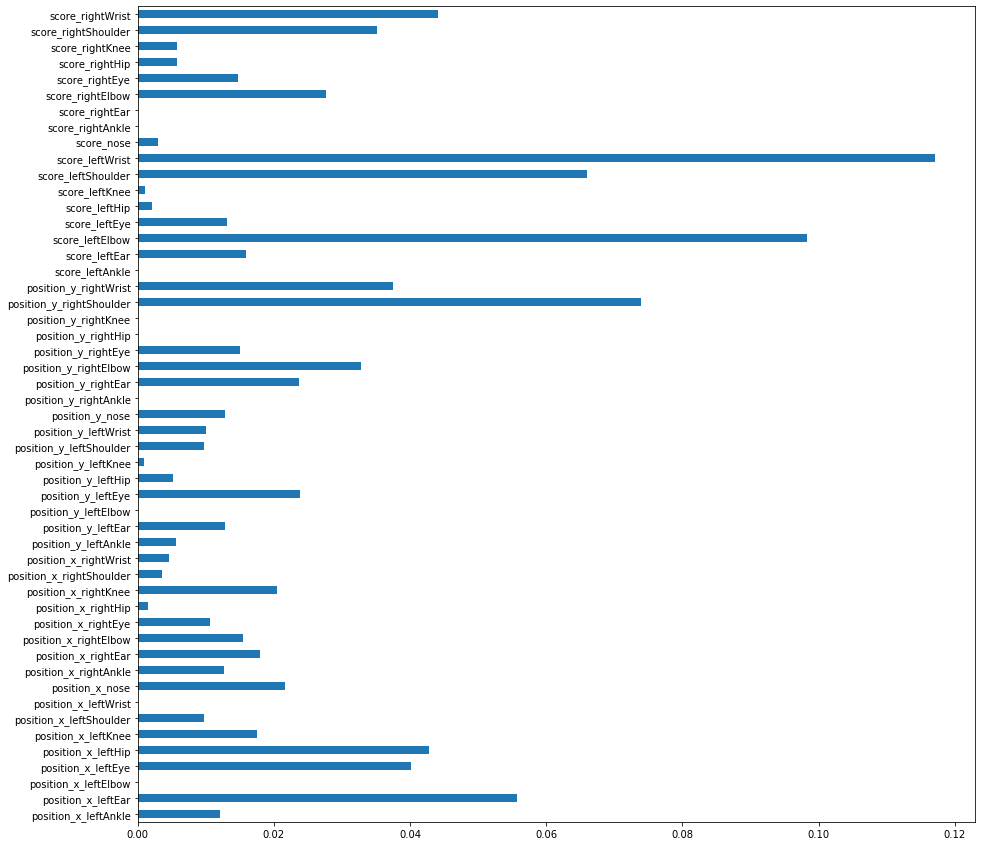

In [28]:
import matplotlib.pyplot as plt
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
fig, ax = plt.subplots(1,1, figsize=(15, 15))
feat_importances.plot(kind='barh', ax=ax)
plt.show()

## Cross Validation


In [50]:
from sklearn.model_selection import cross_val_score
rfc_cv_score = cross_val_score(rf_model, X_train, y_train, cv=10, scoring='roc_auc')
rfc_cv_score.mean()

0.9445670995670998